In [2]:
import os
from os.path import join

data_path = 'INRIAPerson/'
annot_path = join(data_path, 'Train/annotations/')
annotation_paths = [join(annot_path, p) for p in os.listdir(annot_path)]

In [3]:
def parsePascalFormat(lines, root):
    image_path = lines[2].split(' ')[-1][1:-1]
    annots = list(filter(lambda l: l != '', lines[12:]))
    
    parsed_annots = [
        annots[i].translate({ord(c): None for c in '()-,'}).split(' ')[-5:]
        for i in range(5, len(annots), 6)
    ]
    
    bb = [
        [int(a[0]), int(a[1]), int(a[3]), int(a[4])]
        for a in parsed_annots
    ]
    return join(root, image_path), bb

def readFile(path):
    with open(path, 'r') as f:
        return f.read()
    
def bb_normalise(bbs, path):
    image = imread(path)
    h, w = image.shape[:2]
    return [[
        int(bb[0] / w * IM_SIZE),
        int(bb[1] / h * IM_SIZE),
        int(bb[2] / w * IM_SIZE),
        int(bb[3] / h * IM_SIZE)
    ] for bb in bbs]

def drawImageBB(path, boundingboxes):
    rsz_image = imresize(imread(path), (IM_SIZE, IM_SIZE))
    ax = plt.imshow(rsz_image)
    
    for bb in boundingboxes:
        left_bottom = (bb[0], bb[1]) 
        width = bb[2] - bb[0]
        height = bb[3] - bb[1]

        ax.axes.add_patch(patches.Rectangle(
            left_bottom, width, height, fill=False, color='r'
        ))
        
    plt.show()
    
def overlap(a, b):
    (ya1, xa1, ya2, xa2) = a
    (yb1, xb1, yb2, xb2) = b
    horizontal_overlap = np.maximum(0, np.minimum(xa2, xb2) - np.maximum(xa1, xb1))
    vertical_overlap = np.maximum(0, np.minimum(ya2, yb2) - np.maximum(ya1, yb1))
    return horizontal_overlap * vertical_overlap

def area(a):
    (y1, x1, y2, x2) = a
    return (y2 - y1) * (x2 - x1)

def IOU(a, b):
    intersection = overlap(a, b)
    return intersection / (area(a) + area(b) - intersection)    

In [11]:
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

IM_SIZE = 416
CELL_SIZE = 32
NUM_CELLS = IM_SIZE // CELL_SIZE

annotations = [
    parsePascalFormat(readFile(p).split('\n'), data_path)
    for p in annotation_paths
]

In [5]:
from tiny_yolo_v2 import TinyYOLOv2
%load_ext autoreload
%autoreload 2

net = TinyYOLOv2(IM_SIZE)
net.loadWeightsFromDarknet('yolov2-tiny-voc.weights')

c:\users\rameg\miniconda2\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading weights from yolov2-tiny-voc.weights


c:\users\rameg\miniconda2\envs\tf\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
c:\users\rameg\miniconda2\envs\tf\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


416


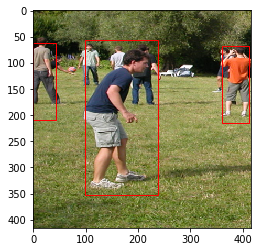

In [25]:
p = annotations[190][0]

image = imresize(imread(p), (IM_SIZE, IM_SIZE)) / 255
boxes = net.forward(image)

drawImageBB(p, boxes)

- assign responsibility to one predictor per cell based on which predictor in that cell has highest current IOU with ground truth
- normalise bounding box height and width to fall in 0 - 1
- x, y bb coords = offsets of a particluar grid cell location